# Final Project for the lecture "Computer Vision and 3D reconstruction"
Winter term 2022 /23

By Robin jansen, Konstantin Dibbern and Stefan Wahl

This Notbook contains the full procedure we used to train and evaluate our model. For the purpose of comprehensibility, we migrated the different basic building blocks into different auxilliary files contained in the folder "./utils/". For details about the implementations, please refer to these files.

# 0. Load packages and functions

In [2]:
#packages
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import json
import zipfile

#Building blocks
from utils.ObjectiveFunctions import *
from utils.CreateTestTrainValSplit import splitter_downsize
from utils.DataSet import ImSegDataSet
import utils.unet_utils as ut
from utils.unet_utils import train
from utils.image_utils import prepare_image_torch
import utils_main as utm

c:\ProgramData\Anaconda3\envs\ml_homework\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# 1. Getting started
In this repository, we already provide a downscaled training set. If you want to use this set, you can directly skip to chapter 2 of this notebook. If you want to create your own data set, with a different downscaling factor than 15, you have to follow the instructions in this chapter.

In order to run our precedure, you have to provide the necessary data set. Please download the data set from the kaggle page into the root folder of this repository:

https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

for details about the data, please refer to this kaggle page or to

https://www.tugraz.at/index.php?id=22387

wher the data set has been published first.

To create your own data set, please run the following cells after you have ddownloaded the data set.

In [ ]:

with zipfile.ZipFile("./archive.zip", 'r') as zip_ref:
    zip_ref.extractall("./archive")

To test and train our model, we need independent test and training data. To ensure that we do not mix up the two data set, we split the data obtained from the data set into a test set, a validation set and a training set. To speed up the data preprocessing during the training of the model, we save downscaled versions of the images. This may take some time. The three resulting subsets of the traiing set are stored in the directory "./data/"

In [ ]:
val_size = 50 #Size of the validation set
test_size = 50 #Size of the test set
scaling_factor = 7 #Factor by which the images are downscaled

splitter_downsize(source_X="./archive/dataset/semantic_drone_dataset/original_images/",source_Y="./archive/dataset/semantic_drone_dataset/label_images_semantic/",val_size=val_size,test_size=test_size,scaling_factor=scaling_factor)

# 2. Train the UNet

In this section, a new Unet is trained. If you want to load a pretrained model, skip directly to chapter 3.

The hyperparameters for the training are all set in the below config file. For a brief explanation of the different parameters, please refer to the comments behind each paramer in the dictionary.

In [3]:
#Set the training parameters here
config = {
    "lr": 0.0001,                   #Learning rate used in th eoptimization of the model parameters
    "loss":"weightedCE",            #Name of the ojective function used in the optimization of the model parameters. This value is used as key to extract the actual loss function from the loss function dictionary
    "batchSize":15,                 #Number of patches used in each mini batch
    "patchSize":256,                #Size of the patches taken from the images stored in the data set. Has to be a of size 2^k k = 1,2,3,4,5,....
    "nEpochs":10,                   #Number of epochs 
    "bufferSize":5,                 #Number of images that are stored in the image buffer during the training
    "bufferUpdateFreq":1,           #Frequency of updating the images in the image buffer
    "bufferPickSize":3,             #Number of images sampled from the buffer in each sampling step
    "batchSizeDataLoaderTrain":1,   #Number of images sampled from the data set 
    "useRotation":False,            #Enable usage of rotated training images in the training
    "useMirroring":False,           #Enable usage of mirrored training images in the training
    "scalingFactor":10,             #Factor by which the images loaded from the preprocessed data set are scaled down
    "useOriginal":True,             #If this is true, the images taken from the from the data set are not downscaled further
    "classCountThreshold":3,        #Minimum number of different classes in a patch required to use the patch in the training
    "modelParameters":{"in_channels":3, "out_channels":24, "sizes":[64, 128, 256, 512]},    #Parameters to initialize the shape of the model
    "modelName":"uNet",             #Name of the model family. This value is used as key to extract the actual model from the model dictionary
    "optimizer":"Adam",             #Name of the optimizer. This value is used as key to extract the actual optimizer from the optimizer dictionary
    "BatchFreqValidate":50,         #Frequency (in batches) of applyig the model to the validation set.
    "DropLossFreq":5                #Frequency (in update steps) of saving the stored loss.
}

Initialize the model, the data loaders for validation and training as well as the optimizer used to adapt the model parameters.

In [4]:
#Select the device on which the training runs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Select the objective function
if config["loss"]=="weightedCE":
    print("Use weighted Cross Entropy")

    #Load the prioir
    with open("./empiricalPriorTrainingSet.txt","r") as file:
        a = np.loadtxt(file)
    file.close()

    prior = torch.tensor(a[:,1])
    prior = np.where(prior ==0,np.ones_like(prior),prior)

    w = 1 / prior
    w = torch.tensor(w)

    CE_loss = nn.CrossEntropyLoss(weight=w.float())

    def weightedCE(inputs,targets):
        return CE_loss(inputs,targets)
    
    crit = weightedCE

else:
    crit = utm.loss_dict[config["loss"]]

#Initialize the model
model = utm.model_dict[config["modelName"]](**config["modelParameters"]).to(device)
model.apply(ut.initialize_weights)

#Initialize the objective function
optimizer = utm.optimizer_dict[config["optimizer"]](model.parameters(), lr = config["lr"])

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=config["batchSizeDataLoaderTrain"],shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

#Tag to identify the training run
tag = "training_run_1"
print(f"\nThe tag for this training run is:\n{tag}")

Use weighted Cross Entropy
#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	train
	Number of instances:	300
	Image: (C,H,W):		(3,266,400)
#########################################################################################


#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	validation
	Number of instances:	50
	Image: (C,H,W):		(3,266,400)
#########################################################################################

The tag for this training run is:
training_run_1


Train the model given the above hyper parameters

In [ ]:
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = config["bufferSize"], 
    buffer_update_freq = config["bufferUpdateFreq"],
    buffer_pick_size = config["bufferPickSize"],
    n_epochs = config["nEpochs"],
    patch_size = config["patchSize"],
    batch_size = config["batchSize"],
    tag = tag,
    rotation = config["useRotation"],
    mirroring = config["useMirroring"],
    scaling_factor = config["scalingFactor"],
    use_original = config["useOriginal"],
    threshold=config["classCountThreshold"],
    config = config
    )

# 3 Evaluate the trained model on the test set

If you have not trained a new model in the previous section, use the pretrained model and the corresponding results provided on GitHub. To do this, run the following cell. If you want to use the result from your own training do not run it.

In [5]:
tag = "pretrained_model"

Now the configuration file containing all the information about the training is loaded.

In [6]:
with open(f"./results/{tag}/data/config.json","r") as file:
    config = json.load(file)
file.close()

We start the evaluation by visualizing the training loss, the loss on the validation set, the F1 score on the validation set and the accuracy on the validation set as a function of the training progress.

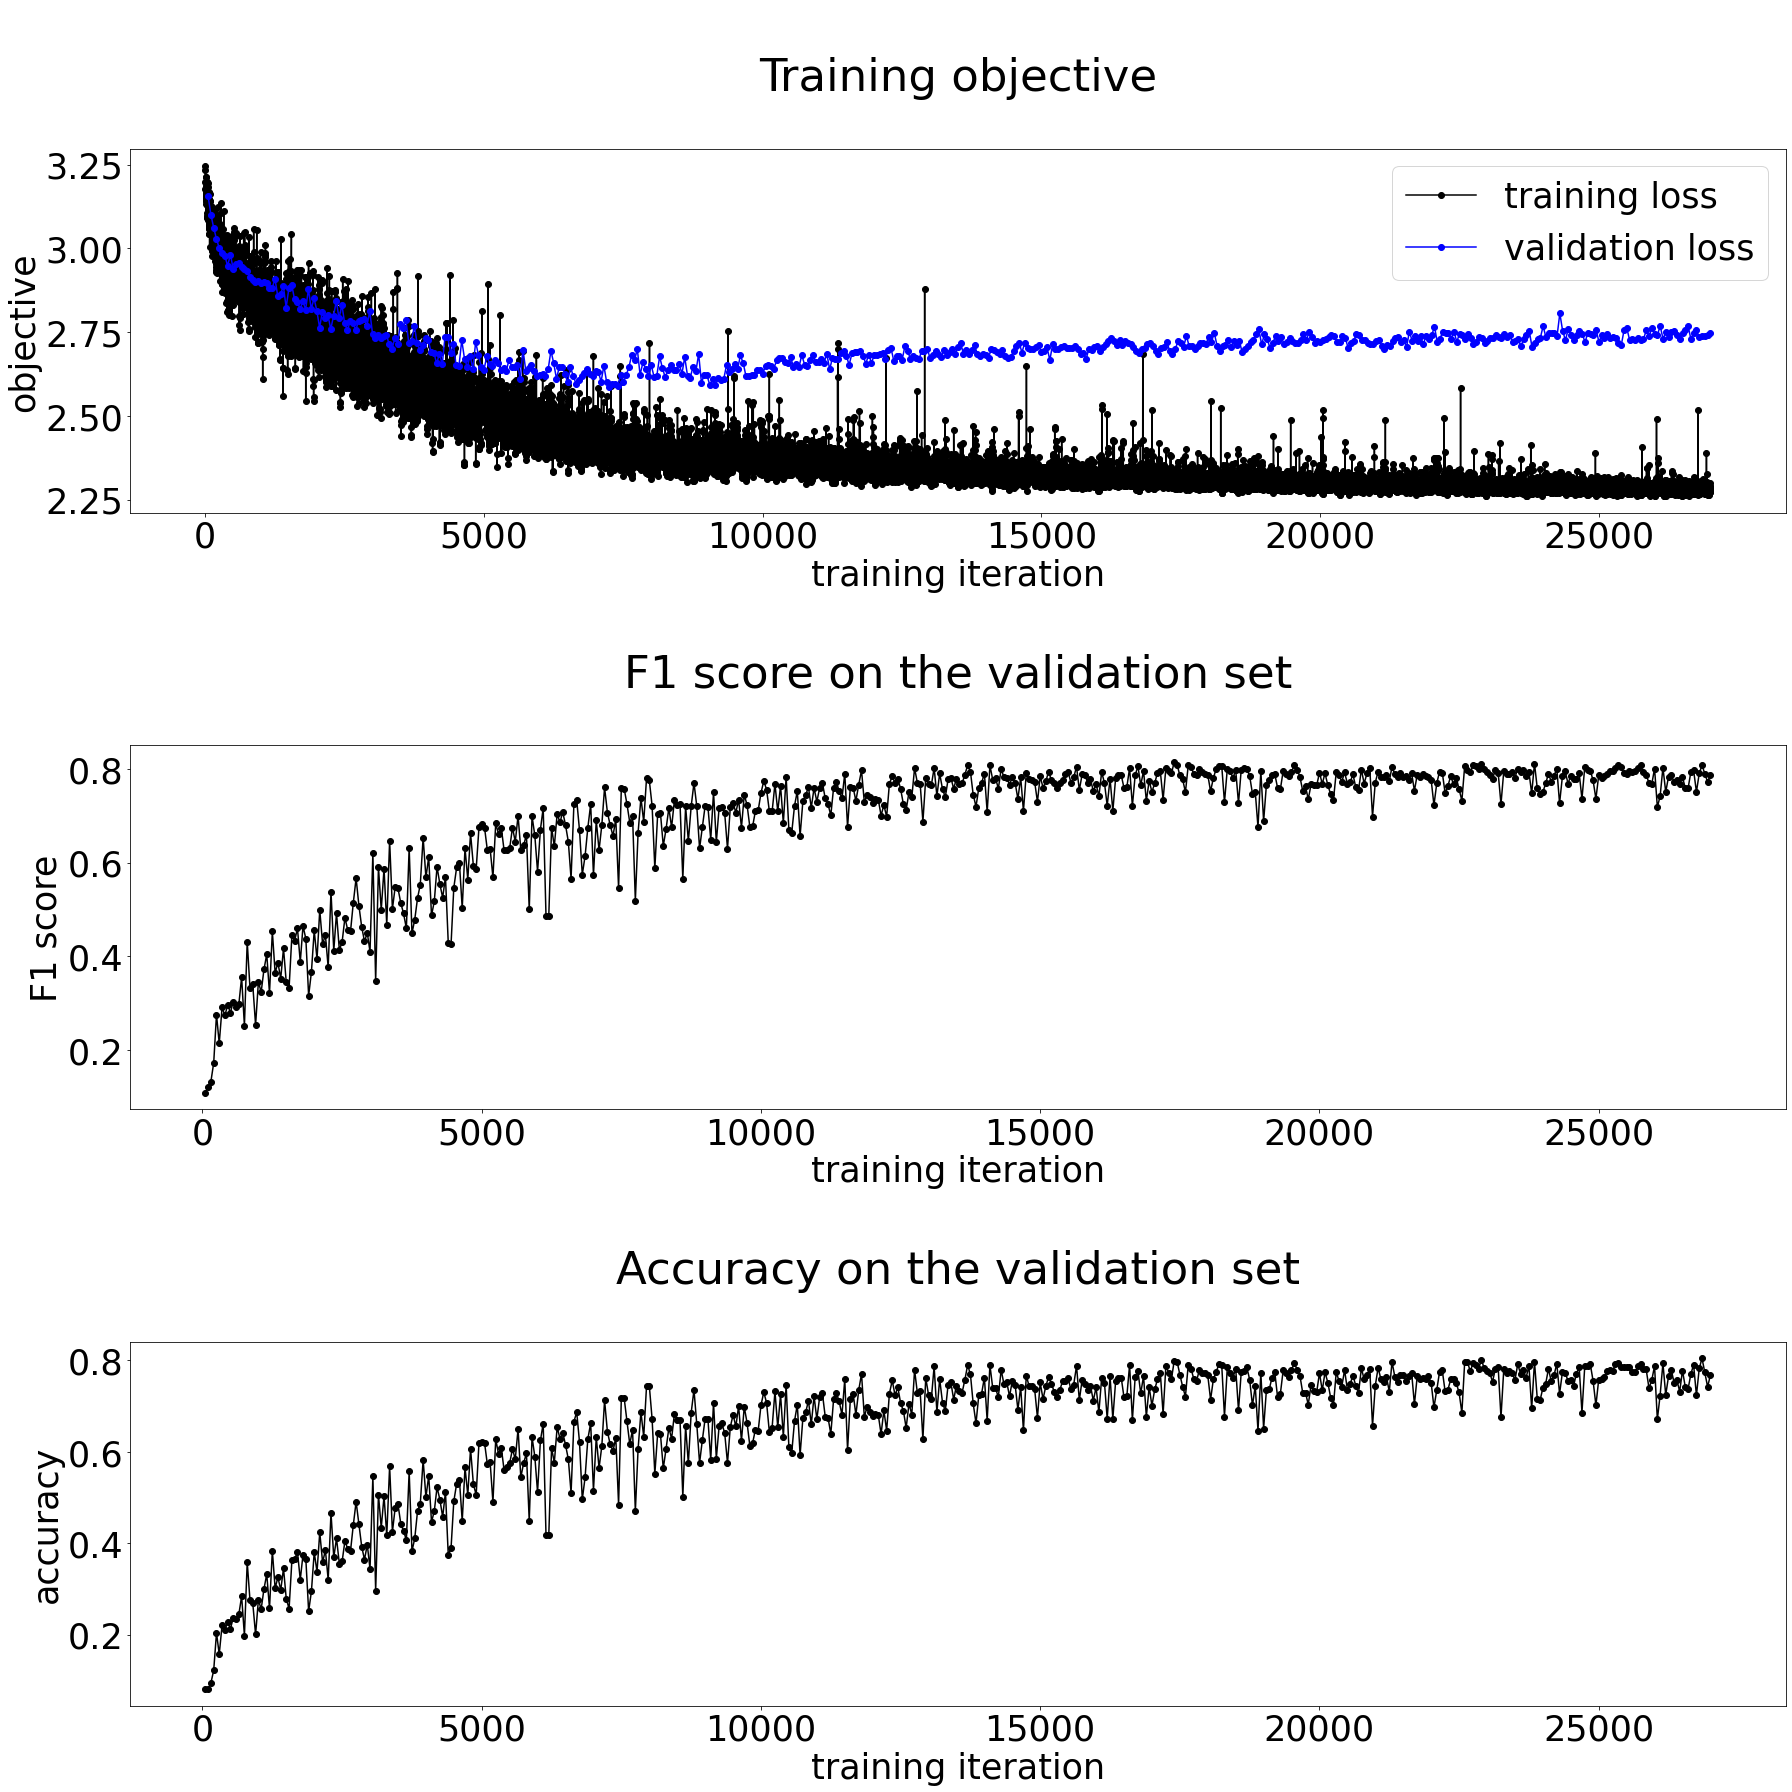

In [7]:
validationAccuracy = utm.plotter_loss(tag = tag)

For furter evaluation, we determine the model which performed best. This is done by selecting the model which has the highest accuracy on the validation set.

In [9]:
#Select the entries where  a model is stored
validationAccuracyReduced = validationAccuracy[(validationAccuracy[:,2] == -1)]

print(validationAccuracyReduced)
print(len(validationAccuracyReduced))

#Get the model for which the validation accuracy is the highest
index_opt = np.argmax(validationAccuracyReduced[:,-1])
print(index_opt)
epoch_opt = int(validationAccuracyReduced[index_opt][1])

print(f"Best model: After epoch {epoch_opt}")

[[ 3.00000000e+02  1.00000000e+00 -1.00000000e+00  1.57322693e-01]
 [ 6.00000000e+02  2.00000000e+00 -1.00000000e+00  2.34317017e-01]
 [ 9.00000000e+02  3.00000000e+00 -1.00000000e+00  2.69371033e-01]
 [ 1.20000000e+03  4.00000000e+00 -1.00000000e+00  2.57588196e-01]
 [ 1.50000000e+03  5.00000000e+00 -1.00000000e+00  2.78474426e-01]
 [ 1.80000000e+03  6.00000000e+00 -1.00000000e+00  3.74746704e-01]
 [ 2.10000000e+03  7.00000000e+00 -1.00000000e+00  4.23727417e-01]
 [ 2.40000000e+03  8.00000000e+00 -1.00000000e+00  4.10493469e-01]
 [ 2.70000000e+03  9.00000000e+00 -1.00000000e+00  4.39120483e-01]
 [ 3.00000000e+03  1.00000000e+01 -1.00000000e+00  3.43728638e-01]
 [ 3.30000000e+03  1.10000000e+01 -1.00000000e+00  4.17074585e-01]
 [ 3.60000000e+03  1.20000000e+01 -1.00000000e+00  4.26908875e-01]
 [ 3.90000000e+03  1.30000000e+01 -1.00000000e+00  4.86421204e-01]
 [ 4.20000000e+03  1.40000000e+01 -1.00000000e+00  5.22288513e-01]
 [ 4.50000000e+03  1.50000000e+01 -1.00000000e+00  4.91386414e

Visualize the distribution of the number of classes per patch during the training. This gives an impression about how many of the patches were rejected.

In [ ]:
utm.plotter_classCouts(tag,config)

Now, the model which has performed best durrring the training is loaded for evaluation on the test set.

In [ ]:
#Set the path to the stored model
load_path = f"results/{tag}/"

#load the configurations
with open(load_path + f"data/config.json","r") as file:
    config_loaded = json.load(file)
file.close()

#Initialize the model
model = utm.model_dict[config_loaded["modelName"]](**config["modelParameters"])

#Load the stored state dict
model.load_state_dict(torch.load(load_path + f"state_dicts/state_dict_epoch-{epoch_opt}.pt",map_location=torch.device(device)))

print(f"Loaded model 'state_dict_epoch-{epoch_opt}.pt' from folder ./{load_path}")

#Evaluation mode
a = model.train(False)

with torch.no_grad():
    torch.save(model.state_dict(),f"results/{tag}/state_dicts/state_dict_epoch-{epoch_opt}_small.pt")

To get a first impression of the performance of our model, we wirst apply it to several images from the test set and plot it aside the ground truth semantic segmentation for visual inspection. In addition, we also show the confusion matrix between the ground truth and the maximum a posteriori labeling obtained from the model prediction.

In [ ]:
#Initialize the test data set
DS_test = ImSegDataSet(PathToDataSet="./data/test_set/",mode = "test")

#Set the indices of the images that shall be evaluated
indices_to_eval = [1,2,3,4,5,6,7,8,9,10]

In [ ]:
utm.plotter_testSet(indices_to_eval,model,DS_test,config,device)

After getting a first impression of the performance of our classifier on the training set, we are now going to a more qualitative examination. To do this, we apply the model which performed best on the validation set to the 50 instances from the test set and compute the the F1 score and the accuracy.

In [ ]:
acc_trained,F1_trained = utm.eval_performance(model = model,DS = DS_test,config = config,device = device)

print(f"The trained model has an accuracy of {round(acc_trained,4) * 100}% on the test set.")
print(f"The trained model has a F1 score of {round(F1_trained,4)} on the test set.")

To determine whether our model has learned anything, we compare it to a classifier, which only samples the label randomly from the prior distribution of the class labels. To do this, we have to determine the prior distribution of the class labels in the training set.

In [ ]:
prior = utm.eval_prior(DS_training)

Given this empirical prioir distribution we can now define a pseudo classifier which samples the prediction randomly following this distribution. 

In [ ]:
priorClf = utm.pseudoClf(prior = prior,patchSize=config["patchSize"]) 

Now we apply this model to the same evaluation as the trained classifier.

In [ ]:
utm.plotter_testSet(model = priorClf,indices_to_eval = indices_to_eval,DS_test = DS_test,config = config,device = device) 

As for the trained model, we compute the accuracy and the F1 score on the test set.

In [ ]:
acc_priorClf,F1_priorClf = utm.eval_performance(model = priorClf,DS = DS_test,config = config,device=device)

print(f"The trained model has an accuracy of {round(acc_priorClf,4) * 100}% on the test set.")
print(f"The trained model has a F1 score of {round(F1_priorClf,4)} on the test set.")

We can observe, that our trained model outperforms the basline classifier which samples labels following the prior distribution. Therefore, we can conclude, that our model, eventhough it is not yet perfect, has learned something.